<a href="https://colab.research.google.com/github/drssharma/timeseries_forecasting_LSTM/blob/main/timeseries_forecasting__LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
df = pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [67]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


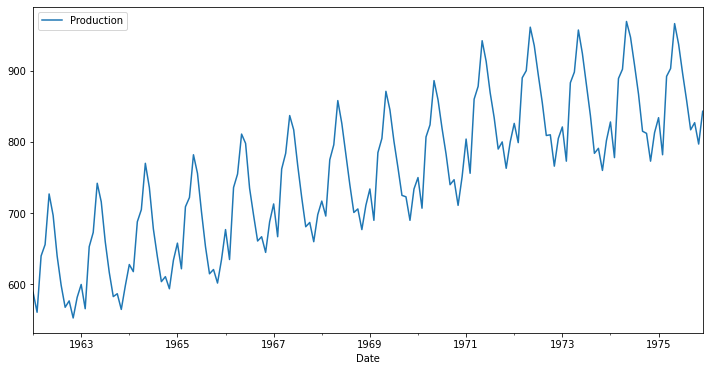

In [69]:
df.plot(figsize=(12,6))

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

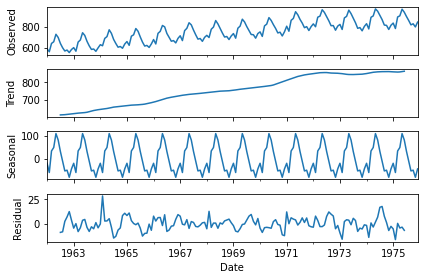

In [71]:
results = seasonal_decompose(df['Production'])
results.plot();

In [72]:
len(df)

168

In [73]:
train = df.iloc[:156]
test = df.iloc[156:]

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [75]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [76]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [77]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [78]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [79]:
n_features = 1
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [81]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [82]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [83]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 2s 7ms/step - loss: 0.0519
Epoch 2/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0246
Epoch 3/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0185
Epoch 4/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0127
Epoch 5/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0128
Epoch 6/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 7/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0043
Epoch 8/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0065
Epoch 9/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0032
Epoch 10/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0028
Epoch 11/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0029
Epoch 12/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0034
Epoch 13/50
144/144 [====

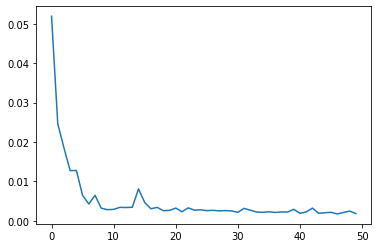

In [84]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [85]:
last_train_batch = scaled_train[-12:]

In [86]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [87]:
model.predict(last_train_batch)

array([[0.6483701]], dtype=float32)

In [88]:
scaled_test[0]

array([0.67548077])

In [89]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [90]:
test_predictions

[array([0.6483701], dtype=float32),
 array([0.61940885], dtype=float32),
 array([0.7988673], dtype=float32),
 array([0.86631626], dtype=float32),
 array([0.9764405], dtype=float32),
 array([0.9559831], dtype=float32),
 array([0.88363767], dtype=float32),
 array([0.785705], dtype=float32),
 array([0.677269], dtype=float32),
 array([0.6371062], dtype=float32),
 array([0.5834154], dtype=float32),
 array([0.62739325], dtype=float32)]

In [91]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [92]:
true_predictions = scaler.inverse_transform(test_predictions)

In [93]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


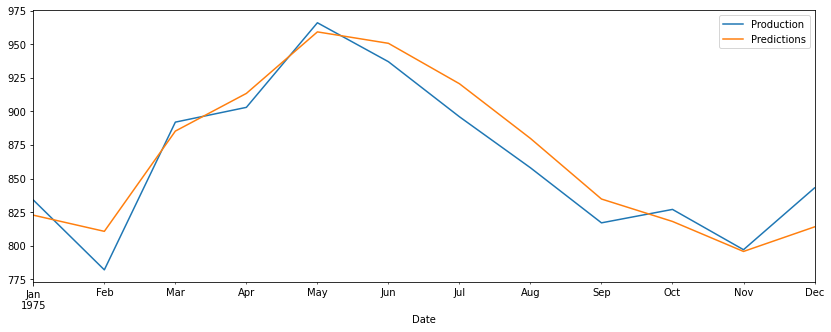

In [94]:
test.plot(figsize=(14,5))

In [95]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

17.454645626859158
